In [1]:
%load_ext autoreload
%autoreload 2

# Classification Task

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fft, ifft

from torchvision import datasets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.insert(0, '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/lib/')
import MURA as mura

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


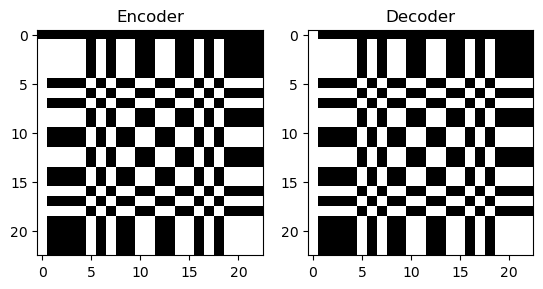

In [5]:
# Test with p=5 to check with paper 
p = 23 # size of array
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

fig, axs = plt.subplots(1,2)
axs = axs.ravel()
axs[0].imshow(A, cmap='gray')
axs[1].imshow(G, cmap='gray')
axs[0].set_title("Encoder")
axs[1].set_title("Decoder")
plt.show()

# Load MNIST Data

In [39]:
class FFT_convolve(object):
   
   #     Parameters
   #    ----------
   #   img: 2D numpy array
   #         The original image with format of [c, h, w]
   #     
   # 
     
    def __init__(self, A):
        self.encoder = A
        self.p = A.shape[0]
        
    def __call__(self, img):
        # Do convolution via FFT   
        fft_A = torch.fft.fft2(self.A)
        fft_img = torch.fft.fft2(img)
        conv_Aimg = torch.real(torch.fft.ifft2(torch.mul(fft_A,fft_img)))
        conv_Aimg = torch.roll(conv_Aimg, [int((self.p-1)/2),int((self.p-1)/2)], axis=(0,1))
        #img = FFT_convolve(np.squeeze(img.numpy()), self.A, self.p)
        #img = torch.unsqueeze(torch.tensor(img), 0)

        return conv_Aimg#Image.fromarray(img)

    def __repr__(self):
        return self.__class__.__name__+'()'

In [24]:
# Compute MURA encoder and decoder
p = 23 # size of array
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

# Load training and testing data from PyTorch
size = A.shape[0]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    #transforms.Normalize(mean=0., std=(1/255.)),
                    # Apply MURA encoder
                    transforms.Lambda(lambda x: torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(x.numpy()), A,p), dtype= torch.float), 0)),
                    #transforms.Lambda(mura.get_D),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)
test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    #transforms.Normalize(mean=0., std=(1/255.)),
                    # Apply MURA encoder
                    #transforms.Lambda(mura.get_D),
                    transforms.Lambda(lambda x: torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(x.numpy()), A,p), dtype= torch.float), 0)),
                    transforms.Normalize(0, 1)
                ]) 
)

In [25]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=0),
}

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.kernel = 3
        # 1 input image channel, 8 output channels, 2x2 square convolution kernel
        self.conv1 = nn.Conv2d(1, 8, self.kernel)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, self.kernel)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = (F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 4* 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [39]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3) 

In [40]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.109
[1,   200] loss: 0.084
[1,   300] loss: 0.059
[1,   400] loss: 0.040
[1,   500] loss: 0.034
[1,   600] loss: 0.027
[2,   100] loss: 0.022
[2,   200] loss: 0.021
[2,   300] loss: 0.017
[2,   400] loss: 0.017
[2,   500] loss: 0.015
[2,   600] loss: 0.014
Finished Training


In [42]:
# Save model
PATH = '../models/mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [43]:
# Load model
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [44]:
dataiter = iter(loaders['test'])
images, labels = dataiter.next()

In [45]:
outputs = net(images)

In [46]:
_, predicted = torch.max(outputs, 1)

In [48]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 91 %


In [62]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.1f} %')

Accuracy for class:     0 is 96.8 %
Accuracy for class:     1 is 98.0 %
Accuracy for class:     2 is 82.5 %
Accuracy for class:     3 is 86.1 %
Accuracy for class:     4 is 94.0 %
Accuracy for class:     5 is 95.3 %
Accuracy for class:     6 is 96.9 %
Accuracy for class:     7 is 93.6 %
Accuracy for class:     8 is 84.3 %
Accuracy for class:     9 is 84.5 %


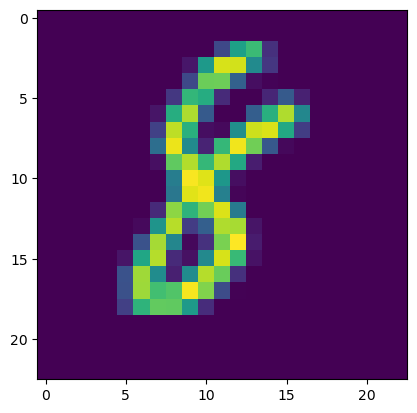

In [71]:
plt.imshow(mura.FFT_convolve(images[0][0].numpy(), G))

tensor(8)


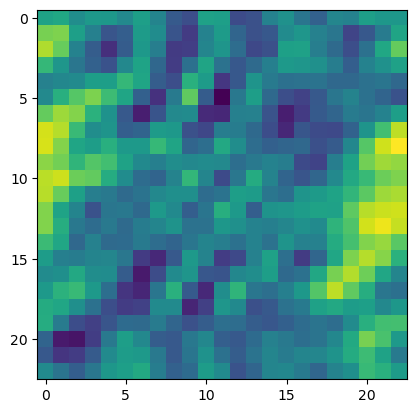

In [66]:
plt.imshow(images[0][0])
print(labels[0])